# Importing Libraries

In [1]:
import pandas as pd
import random
import numpy as np
import matplotlib.pyplot as plt
import datetime
import seaborn as sns

In [2]:
%run "Stock Data.ipynb".ipynb
%run "Binance API.ipynb".ipynb
%run "RiskMetrics.ipynb".ipynb
%run "PnL Computation.ipynb".ipynb

# Importing Data

## Tickers

In [3]:
binance_api_key='E90xR7UnO2oeP3lrgC50zkqUuAqyyXs4uSlAGcqIVO9n90ELrFI4gfVI2HGGxxCj'
binance_api_secret='Inls2xYl9FqPi0zlIrucfxG81drx7w6Pv6SzYFxMNoAcwDjlCKug7zUM9zB3lF9h'
Binance=BinanceAPI(binance_api_key,binance_api_secret)

In [4]:
#stocks=pd.read_html('https://en.wikipedia.org/wiki/EURO_STOXX_50')[4]
#tickers=stocks['Ticker'].to_list()

## Market Data

In [5]:
start_date=datetime.datetime(2023,12,1)
enddate=start_date+datetime.timedelta(500)

In [6]:
quantities_api=Binance.binance_api.user_asset()
current_quantities=pd.DataFrame(quantities_api).sort_values(by='free',ascending=False)
current_quantities['asset']=current_quantities['asset']+'USDT'
current_quantities=current_quantities.set_index('asset')

In [7]:
#today_price=Binance.get_price(holding_tickers,date=datetime.datetime.today()).T
#today_price.columns=['Mark To Market']

In [8]:
trade_history=pd.read_excel('Trade History Reconstructed.xlsx')
price=get_trade_in_usdt(trade_history)

In [9]:
book_cost=get_book_cost(price)
realized_pnl,profit_and_loss=get_pnl(book_cost,price)
historical_positions=get_historical_positions(price)
historical_positions.columns=historical_positions.columns+'USDT'
historical_positions=historical_positions.sort_index()

In [10]:
price_of_positions=Binance.get_price(historical_positions.columns,datetime.datetime(2024,5,1))
price_of_positions.index=pd.to_datetime(price_of_positions.index)
price_of_positions=price_of_positions.sort_index()

In [11]:
dic={}
for key in profit_and_loss:
    dic[key]=profit_and_loss[key].to_dict()

In [12]:
realized_pnl_time=pd.DataFrame(dic).sort_index().fillna(method='ffill').fillna(0)
realized_pnl_time.index=pd.to_datetime(realized_pnl_time.index).round(freq='d')
realized_pnl_time=realized_pnl_time.groupby(realized_pnl_time.index).sum()

In [13]:
tickers=Binance.get_market_cap()['Ticker'].iloc[:75].to_list()
holding=Binance.get_inventory()
condition=holding.index!='Total'
holding_tickers=holding.index[condition]
holding_tickers=holding_tickers.to_list()
tickers=sorted(list(set(tickers+holding_tickers)))
last_book_cost=book_cost.iloc[-1]
pnl=pd.concat([last_book_cost,holding.loc[condition],realized_pnl],axis=1)
pnl.columns=['Book Cost','Price in USDT','Weights','Realized PnL']
pnl['Book Cost']=(pnl['Book Cost']*current_quantities['free'].astype(float))
pnl['Unrealized PnL']=(pnl['Price in USDT']-pnl['Book Cost']).round(2)
pnl=pnl.fillna(0)
pnl['Weights']=pnl['Weights'].round(4)
pnl['Total PnL']=pnl['Unrealized PnL']+pnl['Realized PnL']
pnl.loc['Total']=pnl.sum()
pnl.sort_values(ascending=False,by='Price in USDT')

,Book Cost,Price in USDT,Weights,Realized PnL,Unrealized PnL,Total PnL
Total,2184.935036,4072.373899,1.0000,-131.886217,1887.44,1755.553783
OMUSDT,526.319895,1796.517929,0.4411,0.000000,1270.20,1270.200000
BTCUSDT,601.021649,846.467711,0.2079,3.537078,245.45,248.987078
JASMYUSDT,387.458505,504.935835,0.1240,0.000000,117.48,117.480000
SOLUSDT,281.200518,424.084353,0.1041,0.000000,142.88,142.880000
ETHUSDT,250.747339,251.621614,0.0618,0.000000,0.87,0.870000
TRXUSDT,76.868953,195.854199,0.0481,-10.723889,118.99,108.266111
BBUSDT,60.176053,51.605526,0.0127,-39.733101,-8.57,-48.303101
BNBUSDT,1.142121,1.286727,0.0003,-10.606040,0.14,-10.466040
PEPEUSDT,0.000004,0.000005,0.0000,-38.521986,0.00,-38.521986


In [14]:
data1=Binance.get_price(tickers,start_date)
data2=Binance.get_price(tickers,enddate)
data=data1.combine_first(data2)
data.index=pd.to_datetime(data.index)
#data=data.dropna(axis=1)
n=len(data.columns)
data=data.sort_index()

In [15]:
inventory_weights=(holding['Weights'].apply(lambda x: np.round(x,2))).to_dict()
inventory_weights.pop('Total')

if "USDTUSDT" in inventory_weights:
    
    inventory_weights.pop('USDTUSDT')
else: 
    pass

In [16]:
returns=np.log(1+data.pct_change())
returns.index=pd.to_datetime(returns.index)
with_no_na=returns.columns[np.where((returns.isna().sum()<30))]
returns_to_use=returns[with_no_na]
ex_ante_perf=returns[holding_tickers]
ex_ante_perf_to_use=ex_ante_perf.dropna()

In [17]:
weights_post=dict()

for col in ex_ante_perf.columns:
    
    if col in inventory_weights.keys():
        weights_post[col]=inventory_weights[col]
        
    else:
        weights_post[col]=0
    
current_weights=np.array(list(weights_post.values()))
current_weights=np.round(current_weights,2)/np.sum(np.round(current_weights,2))

## Positions, Historical Performance and PnL

In [18]:
position=pd.read_excel('Positions.xlsx',index_col=0)

In [19]:
positions,quantities=Binance.get_positions_history(enddate=datetime.datetime.today())

positions=positions.sort_index()

positions.index=pd.to_datetime(positions.index)

positions=pd.concat([position,positions])
positions=positions.loc[~positions.index.duplicated(),:]

positions.to_excel('Positions.xlsx')

positions=positions.interpolate()
positions['Total']=positions.sum(axis=1)

In [20]:
quantities_history=pd.read_excel('Quantities.xlsx',index_col=0)

quantities.index=pd.to_datetime(quantities.index)

quantities=pd.concat([quantities,quantities_history])
quantities=quantities.loc[~quantities.index.duplicated(),:]
quantities=quantities.sort_index()

quantities.to_excel('Quantities.xlsx')

In [21]:
quantities_tickers=list(quantities.columns)
price_pnl=Binance.get_price(quantities_tickers,date=quantities.index[0])

In [22]:
price_pnl.index=pd.to_datetime(price_pnl.index)
pnl_history=pd.DataFrame()
pnl_history.index=quantities.index
pnl_history=pnl_history.sort_index()
for col in quantities:
    
    pnl_history[col]=quantities[col]*(price_pnl[col]-book_cost.iloc[-1][col])

pnl_history['Total']=pnl_history.sum(axis=1) +realized_pnl.sum()[0]

In [23]:
pnl_history['Total']

2024-09-23    -378.365173
2024-09-24    -354.861834
2024-09-25    -362.331965
2024-09-26    -276.632747
2024-09-27    -260.113627
                 ...     
2024-11-28    1296.238786
2024-11-29    1338.021317
2024-11-30    1400.498824
2024-12-01    1387.700221
2024-12-02    1418.524583
Name: Total, Length: 71, dtype: float64

In [24]:
#eurusd=Binance.get_price(['EURUSDT'],date=pnl_history.index[0])

In [25]:
ptf_tickers=list(positions.columns)
ptf_tickers.remove('USDTUSDT')

In [26]:
weights_ex_post=positions.copy()
weights_ex_post=weights_ex_post.drop(columns=['USDTUSDT'])
weights_ex_post=weights_ex_post.apply(lambda x: x/weights_ex_post['Total'])

In [27]:
binance_data=Binance.get_price(ptf_tickers,date=datetime.datetime(2024,5,11))
binance_data.index=pd.to_datetime(binance_data.index)
binance_data=binance_data.sort_index()
binance_data=np.log(1+binance_data.pct_change())


LDUMAUSDT not retrieved
Total not retrieved


In [28]:
weight_date=set(weights_ex_post.index)
binance_date=binance_data.index

In [29]:
common_date=binance_date.intersection(weight_date)

binance_data=binance_data.loc[common_date]

In [30]:
historical_ptf=pd.DataFrame()

for col in binance_data:
    historical_ptf[col]=weights_ex_post[col]*binance_data[col]
    
historical_ptf['Historical Portfolio']=historical_ptf.sum(axis=1)

<AxesSubplot:>

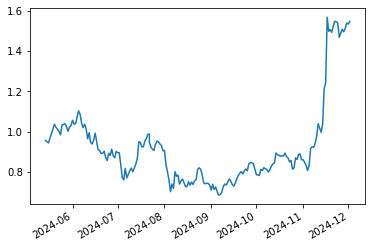

In [31]:
#historical_ptf.dropna(axis = 0, how = 'all', inplace = True)

(1+historical_ptf['Historical Portfolio']).cumprod().plot()

## Ex ante data

In [32]:
ex_ante_ptf=ex_ante_perf.copy()

for key in inventory_weights.keys():
    
    ex_ante_ptf[key]=ex_ante_perf[key]*inventory_weights[key]

ex_ante_ptf=pd.DataFrame(ex_ante_ptf.sum(axis=1))

# Portfolio Optimization

## Class set up

In [33]:
historical_risk=RiskAnalysis(returns_to_use)
current_risk=RiskAnalysis(ex_ante_perf_to_use.iloc[:])
num_asset=len(returns_to_use.columns)
num_asset_current=len(ex_ante_perf_to_use.columns)

In [34]:
returns_to_use.columns

Index(['AAVEUSDT', 'ADAUSDT', 'ALGOUSDT', 'APEUSDT', 'APTUSDT', 'ARBUSDT',
       'ARUSDT', 'ATOMUSDT', 'AVAXUSDT', 'AXSUSDT', 'BCHUSDT', 'BNBUSDT',
       'BONKUSDT', 'BTCUSDT', 'DOGEUSDT', 'DOTUSDT', 'EGLDUSDT', 'EOSUSDT',
       'ETCUSDT', 'ETHUSDT', 'FDUSDUSDT', 'FETUSDT', 'FILUSDT', 'FLOKIUSDT',
       'FLOWUSDT', 'FTMUSDT', 'GALAUSDT', 'GRTUSDT', 'HBARUSDT', 'ICPUSDT',
       'IMXUSDT', 'INJUSDT', 'IOTAUSDT', 'JASMYUSDT', 'LDOUSDT', 'LINKUSDT',
       'LTCUSDT', 'MKRUSDT', 'NEARUSDT', 'NEOUSDT', 'OMUSDT', 'OPUSDT',
       'PEPEUSDT', 'QNTUSDT', 'RAYUSDT', 'RUNEUSDT', 'SANDUSDT', 'SEIUSDT',
       'SHIBUSDT', 'SOLUSDT', 'STXUSDT', 'SUIUSDT', 'THETAUSDT', 'TIAUSDT',
       'TRXUSDT', 'UNIUSDT', 'USDCUSDT', 'VETUSDT', 'WBETHUSDT', 'WBTCUSDT',
       'WLDUSDT', 'XLMUSDT', 'XRPUSDT', 'XTZUSDT'],
      dtype='object')

In [35]:
cash=np.where(returns_to_use.columns=='USDCUSDT')[0][0],np.where(returns_to_use.columns=='FDUSDUSDT')[0][0]
limit_hist=np.where(returns_to_use.columns=='BTCUSDT')[0][0],np.where(returns_to_use.columns=='ETHUSDT')[0][0],np.where(returns_to_use.columns=='SOLUSDT')[0][0],np.where(returns_to_use.columns=='USDCUSDT')[0][0]

## Optimal Portfolio

In [36]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'eq', 'fun': lambda weights: weights[cash[0]]-0.00},
                                                                              
                                                                              {'type': 'eq', 'fun': lambda weights: weights[cash[1]]-0.00}])
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory.iloc[:10].round(4)

,Optimal Weights
OMUSDT,0.3155
TRXUSDT,0.2198
BNBUSDT,0.1559
PEPEUSDT,0.0914
XLMUSDT,0.0909
XRPUSDT,0.0748
SUIUSDT,0.0287
RAYUSDT,0.0116
AAVEUSDT,0.0114
HBARUSDT,0.0000


In [37]:
opt_weights=historical_risk.optimize(objective="sharpe_ratio",constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit_hist[0]]-0.30}])
                                                         #  ,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                        #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
opt_weights=np.round(opt_weights,6)
inventory=historical_risk.inventory(opt_weights)
inventory.columns=['Optimal Weights']

inventory

,Optimal Weights
BTCUSDT,0.300000
OMUSDT,0.299178
TRXUSDT,0.199023
XLMUSDT,0.068298
PEPEUSDT,0.050932
XRPUSDT,0.032932
BNBUSDT,0.026811
SUIUSDT,0.022825


In [38]:
limit=np.where(ex_ante_perf_to_use.columns=='BTCUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='ETHUSDT')[0][0],np.where(ex_ante_perf_to_use.columns=='SOLUSDT')[0][0]

In [39]:
current_optimal_weights=current_risk.optimize(objective="sharpe_ratio")#,constraints=[{'type': 'ineq', 'fun': lambda weights: weights[limit[0]]-0.40}])
                                                           #,{'type': 'ineq', 'fun': lambda weights: weights[limit[1]]-0.15},
                                                            #{'type': 'ineq', 'fun': lambda weights: weights[limit[2]]-0.15}])
current_optimal_weights=np.round(current_optimal_weights,6)
optimal_ptf_current=current_risk.inventory(current_optimal_weights)
optimal_ptf_current.columns=['Optimal Weights']
optimal_ptf_current

,Optimal Weights
TRXUSDT,0.377159
BTCUSDT,0.311955
OMUSDT,0.310886


## Real Portfolio vs Optimal

In [40]:
current_holding_comparison=holding.copy()
current_holding_comparison=current_holding_comparison.loc[current_holding_comparison.index!="Total"]
current_holding_comparison=pd.concat([current_holding_comparison,optimal_ptf_current],axis=1)
current_holding_comparison['Spread']=current_holding_comparison['Weights']-current_holding_comparison['Optimal Weights']
current_holding_comparison['Weights']=current_holding_comparison['Weights'].round(7)
current_holding_comparison=current_holding_comparison.fillna(0)
current_holding_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1796.517929,0.441148,0.310886,0.130262
BTCUSDT,846.467711,0.207856,0.311955,-0.104099
JASMYUSDT,504.935835,0.123991,0.000000,0.000000
SOLUSDT,424.084353,0.104137,0.000000,0.000000
ETHUSDT,251.621614,0.061788,0.000000,0.000000
TRXUSDT,195.854199,0.048093,0.377159,-0.329066
BBUSDT,51.605526,0.012672,0.000000,0.000000
BNBUSDT,1.286727,0.000316,0.000000,0.000000
PEPEUSDT,0.000005,0.000000,0.000000,0.000000


In [41]:
historical_comparison=holding.copy()
historical_comparison=historical_comparison.loc[historical_comparison.index!="Total"]
historical_comparison=pd.concat([historical_comparison,inventory],axis=1)
historical_comparison['Spread']=historical_comparison['Weights']-historical_comparison['Optimal Weights']
historical_comparison['Weights']=historical_comparison['Weights'].round(7)
historical_comparison=historical_comparison.fillna(0)
historical_comparison

,Price in USDT,Weights,Optimal Weights,Spread
OMUSDT,1796.517929,0.441148,0.299178,0.141970
BTCUSDT,846.467711,0.207856,0.300000,-0.092144
JASMYUSDT,504.935835,0.123991,0.000000,0.000000
SOLUSDT,424.084353,0.104137,0.000000,0.000000
ETHUSDT,251.621614,0.061788,0.000000,0.000000
TRXUSDT,195.854199,0.048093,0.199023,-0.150930
BBUSDT,51.605526,0.012672,0.000000,0.000000
BNBUSDT,1.286727,0.000316,0.026811,-0.026495
PEPEUSDT,0.000005,0.000000,0.050932,-0.050932
XLMUSDT,0.000000,0.000000,0.068298,0.000000


# Risk Reward Analysis

In [42]:
opt_ptf=(returns_to_use*opt_weights).sum(axis=1)
curr_opt_ptf=(ex_ante_perf*current_optimal_weights).sum(axis=1)
portfolio_perf=pd.DataFrame()
portfolio_perf['Portfolio']=(ex_ante_perf*current_weights).sum(axis=1)

In [43]:
portfolio_perf['Bitcoin']=returns['BTCUSDT']
portfolio_perf['Optimal']=opt_ptf
portfolio_perf['Current Optimal']=curr_opt_ptf

<AxesSubplot:>

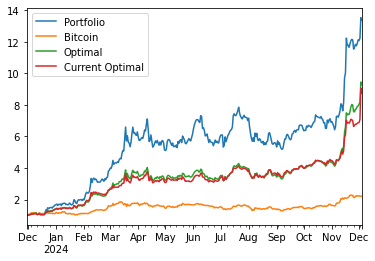

In [44]:
(1+portfolio_perf.loc[:]).cumprod().plot()

In [45]:
current_perf=portfolio_perf.copy()
current_perf=current_perf.loc[historical_ptf.index]
current_perf['Historical Portfolio']=historical_ptf['Historical Portfolio']

<AxesSubplot:>

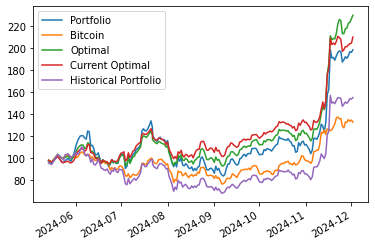

In [46]:
((1+current_perf).cumprod()*100).plot()

In [47]:
((1+current_perf).cumprod()*100).iloc[-10:]

,Portfolio,Bitcoin,Optimal,Current Optimal,Historical Portfolio
2024-11-23,197.102424,135.596067,225.598312,209.274767,154.656666
2024-11-24,196.467510,135.911726,224.521652,207.549142,154.123725
2024-11-25,187.031629,128.947631,212.676917,196.841423,146.949156
2024-11-26,189.132759,127.490870,212.800686,198.254017,148.874744
2024-11-27,191.866152,132.783198,217.256566,201.015965,150.943684
2024-11-28,190.409816,132.479326,217.867771,200.980486,149.674755
2024-11-29,192.733826,134.971167,222.138078,202.526947,151.414174
2024-11-30,196.420434,133.506331,223.075968,203.717353,154.042164
2024-12-01,195.869933,134.578273,226.363187,204.073636,153.524639
2024-12-02,198.121893,132.703379,229.417112,209.657406,154.867822


## Volatilities

In [48]:
vol=historical_risk.portfolio(opt_weights).std()*np.sqrt(252)
vol_ex_ante=historical_risk.variance(opt_weights)

vol,vol_ex_ante

(Portfolio    0.544247
 dtype: float64,
 0.5449567528128504)

In [49]:
vol=current_risk.portfolio(current_weights).std()*np.sqrt(252)
vol_ex_ante=current_risk.variance(current_weights)
vol,vol_ex_ante

(Portfolio    0.637942
 dtype: float64,
 0.6379421091815043)

In [50]:
portfolio_perf.iloc[1:].std()*np.sqrt(252)

Portfolio          0.712017
Bitcoin            0.435815
Optimal            0.544957
Current Optimal    0.553313
dtype: float64

In [51]:
current_risk.tracking_error(current_risk.returns['BTCUSDT'],current_perf['Historical Portfolio'])

0.4318775236986809

## Risk Contribution

In [52]:
perf_analysis=pd.concat([historical_risk.perf_contrib(opt_weights),historical_risk.var_contrib_pct(opt_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
BNBUSDT,0.048525,0.026811,0.004209,0.011452,0.000554,0.010898
BTCUSDT,0.361857,0.300000,0.036975,0.157767,0.057560,0.100206
OMUSDT,15.556224,0.299178,0.885764,0.605146,0.497031,0.108115
PEPEUSDT,0.263597,0.050932,0.017571,0.057957,0.014105,0.043852
SUIUSDT,0.051905,0.022825,0.004175,0.015597,0.001585,0.014012
TRXUSDT,0.413508,0.199023,0.034219,0.098053,0.055140,0.042912
XLMUSDT,0.134042,0.068298,0.011304,0.036714,0.009137,0.027577
XRPUSDT,0.070602,0.032932,0.005784,0.017314,0.001521,0.015793


In [53]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_optimal_weights),current_risk.var_contrib_pct(current_optimal_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,0.806644,0.310886,0.439253,0.481149,0.378556,0.102593
BTCUSDT,0.130698,0.311955,0.173988,0.118697,0.056958,0.061739
TRXUSDT,0.606819,0.377159,0.386759,0.400154,0.329689,0.070465


In [54]:
perf_analysis=pd.concat([current_risk.perf_contrib(current_weights),current_risk.var_contrib_pct(current_weights)],axis=1)
perf_analysis

,Performance Contribution,Initial Weights,Last Weights,Variance Contribution in %,Idiosyncratic Risk in %,Correlation in %
OMUSDT,1.153183,0.444444,0.661105,0.675974,0.554087,0.121887
BTCUSDT,0.088871,0.212121,0.124552,0.085900,0.018861,0.067040
JASMYUSDT,0.056049,0.121212,0.073352,0.112021,0.035476,0.076545
SOLUSDT,0.036330,0.101010,0.056832,0.069972,0.010423,0.059549
ETHUSDT,0.005751,0.060606,0.027459,0.027874,0.002645,0.025229
TRXUSDT,0.081259,0.050505,0.054524,0.018099,0.004234,0.013865
BBUSDT,-0.004840,0.010101,0.002177,0.010160,0.000404,0.009756


# Value At Risk

## Historical

### Optimal Weights

In [55]:
var,cvar=historical_risk.historical_var(opt_weights)
(var,cvar)

(-0.043010576556682154, -0.06360074242595962)

### Current Weights

In [56]:
var,cvar=current_risk.historical_var(current_weights)
(var,cvar)

(-0.04765187970997975, -0.0670389294038466)

In [57]:
historical_var=current_risk.returns*current_weights
historical_var['Portfolio']=historical_var.sum(axis=1)
historical_var=historical_var.sort_values(by='Portfolio')
centile=0.05
row=round(historical_var.shape[0]*centile)

In [58]:
var=historical_var.iloc[row]
var

OMUSDT      -0.017293
BTCUSDT     -0.010869
JASMYUSDT   -0.009844
SOLUSDT     -0.007700
ETHUSDT      0.000953
TRXUSDT     -0.003148
BBUSDT      -0.000126
BNBUSDT     -0.000000
PEPEUSDT    -0.000000
Portfolio   -0.048028
Name: 2024-11-25 00:00:00, dtype: float64

In [59]:
cvar=historical_var.iloc[:row+1].mean()
cvar

OMUSDT      -0.039388
BTCUSDT     -0.007239
JASMYUSDT   -0.009900
SOLUSDT     -0.006666
ETHUSDT     -0.002259
TRXUSDT     -0.000829
BBUSDT      -0.000759
BNBUSDT      0.000000
PEPEUSDT     0.000000
Portfolio   -0.067039
dtype: float64

## Parametric

### Optimal Weights

In [60]:
var,cvar=historical_risk.parametric_var(opt_weights)

(var,cvar)

(-0.05646626017893024, -0.07237413349309574)

### Current Weights

In [61]:
var,cvar=current_risk.parametric_var(current_weights)

(var,cvar)

(-0.06610103449531733, -0.08472325029913919)

## Multivariate

### Optimal Weights

In [62]:
perf=performance(historical_risk.multivariate_distribution(),opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.05009626914582369, -0.06449204030696574)

### Current Weights

In [63]:
perf=performance(current_risk.multivariate_distribution(),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()
(var,cvar)

(-0.061466150254062484, -0.07856595697201559)

In [64]:
scenario_multivariate={}

for i in range(50):
    multivariate_distrib=pd.DataFrame(current_risk.multivariate_distribution(),columns=current_risk.returns.columns)
    multivariate_distrib=multivariate_distrib*current_weights
    multivariate_distrib=multivariate_distrib[multivariate_distrib.columns[current_weights>0]]

    multivariate_distrib['Portfolio']=multivariate_distrib.sum(axis=1)
    multivariate_var=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]['Portfolio']
    results=multivariate_distrib.sort_values(by='Portfolio').iloc[int(multivariate_distrib.shape[0]*0.05)]

    scenario_multivariate[i]=results.to_dict()

mean_scenario_multivariate=pd.DataFrame(scenario_multivariate).T.mean()
mean_scenario_multivariate

OMUSDT      -0.039046
BTCUSDT     -0.006356
JASMYUSDT   -0.007094
SOLUSDT     -0.004784
ETHUSDT     -0.002091
TRXUSDT     -0.000953
BBUSDT      -0.000800
Portfolio   -0.061123
dtype: float64

## Copulas

## Gaussian Copula

### Optimal Weights

In [65]:
cop=historical_risk.gaussian_copula()
perf=performance(cop,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05027761817221648, -0.06415248024886973)

### Current Weights

In [66]:
cop=current_risk.gaussian_copula()
perf=performance(cop,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06025270935333048, -0.07752497899025788)

In [67]:
scenario_gaussian={}

for i in range(100):
    gaussian_copula_distrib=pd.DataFrame(current_risk.gaussian_copula(),columns=current_risk.returns.columns)

    gaussian_copula_distrib=gaussian_copula_distrib*current_weights
    gaussian_copula_distrib=gaussian_copula_distrib[gaussian_copula_distrib.columns[current_weights>0]]

    gaussian_copula_distrib['Portfolio']=gaussian_copula_distrib.sum(axis=1)
    gaussian_var=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gaussian_copula_distrib.sort_values(by='Portfolio').iloc[int(gaussian_copula_distrib.shape[0]*0.05)]
    
    scenario_gaussian[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gaussian).T.mean()
mean_scenario_gaussian

OMUSDT      -0.038556
BTCUSDT     -0.005687
JASMYUSDT   -0.008511
SOLUSDT     -0.004298
ETHUSDT     -0.002035
TRXUSDT     -0.001072
BBUSDT      -0.000838
Portfolio   -0.060999
dtype: float64

## Student Copula

### Optimal Weights

In [68]:
t_copula=historical_risk.t_copula()
perf=performance(t_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.049896235221180606, -0.06530623550964185)

### Current Weights

In [69]:
t_copula=current_risk.t_copula()
perf=performance(t_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.06400444952830786, -0.08226236073012992)

In [70]:
scenario_t_copula={}

for i in range(100):
    
    t_copula_distrib=pd.DataFrame(current_risk.t_copula(),columns=current_risk.returns.columns)
    t_copula_distrib=t_copula_distrib*current_weights
    t_copula_distrib=t_copula_distrib[t_copula_distrib.columns[current_weights>0]]
    t_copula_distrib['Portfolio']=t_copula_distrib.sum(axis=1)
    t_copula_var=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=t_copula_distrib.sort_values(by='Portfolio').iloc[int(t_copula_distrib.shape[0]*0.05)]
    
    scenario_t_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_t_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.040972
BTCUSDT     -0.005295
JASMYUSDT   -0.007322
SOLUSDT     -0.004903
ETHUSDT     -0.001993
TRXUSDT     -0.000933
BBUSDT      -0.000863
Portfolio   -0.062281
dtype: float64

## Gumbel Copula

### Optimal Weights

In [71]:
gumbel_copula=historical_risk.gumbel_copula()
perf=performance(gumbel_copula,opt_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.09145456204710808, -0.1286141327415255)

### Current Weights

In [72]:
gumbel_copula=current_risk.gumbel_copula(theta=2)
perf=performance(gumbel_copula,current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.1070809670828284, -0.15205047887466797)

In [73]:
scenario_gumbel_copula={}

for i in range(100):
    
    gumbel_copula_distrib=pd.DataFrame(current_risk.gumbel_copula(),columns=current_risk.returns.columns)
    gumbel_copula_distrib=gumbel_copula_distrib*current_weights
    gumbel_copula_distrib=gumbel_copula_distrib[gumbel_copula_distrib.columns[current_weights>0]]
    gumbel_copula_distrib['Portfolio']=gumbel_copula_distrib.sum(axis=1)
    gumbel_copula_var=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]['Portfolio']
    results=gumbel_copula_distrib.sort_values(by='Portfolio').iloc[int(gumbel_copula_distrib.shape[0]*0.05)]
    
    scenario_gumbel_copula[i]=results
    
mean_scenario_gaussian=pd.DataFrame(scenario_gumbel_copula).T.mean()
mean_scenario_gaussian

OMUSDT      -0.099089
BTCUSDT     -0.002632
JASMYUSDT   -0.002815
SOLUSDT     -0.002036
ETHUSDT     -0.000582
TRXUSDT     -0.001509
BBUSDT      -0.000149
Portfolio   -0.108812
dtype: float64

## Monte Carlo

### Optimal

In [74]:
spot=data[with_no_na].iloc[-1]
monte_carlo=historical_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),opt_weights)

In [75]:
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.05964244699650045, -0.07459416307647133)

### Current Weights

In [76]:
spot=data[ex_ante_perf.columns].iloc[-1]
monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
perf=performance(monte_carlo[1].fillna(0),current_weights)
var=np.percentile(perf,5)
cvar=perf[perf<var].mean()

var,cvar

(-0.0666420947356868, -0.08350432543358334)

In [77]:
spot=data[ex_ante_perf.columns].iloc[-1]

scenario_monte_carlo={}

for i in range(100):
    
    monte_carlo=current_risk.monte_carlo(spot,horizon=1/250,stress_factor=1.0)
    monte_carlo_distrib=monte_carlo[1].fillna(0)*current_weights
    monte_carlo_distrib=monte_carlo_distrib[monte_carlo_distrib.columns[current_weights>0]]
    monte_carlo_distrib['Portfolio']=monte_carlo_distrib.sum(axis=1)
    monte_carlo_var=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]['Portfolio']
    results=monte_carlo_distrib.sort_values(by='Portfolio').iloc[int(monte_carlo_distrib.shape[0]*0.05)]
    
    scenario_monte_carlo[i]=results
    
mean_scenario_monte_carlo=pd.DataFrame(scenario_monte_carlo).T.mean()
mean_scenario_monte_carlo

OMUSDT      -0.046173
BTCUSDT     -0.006321
JASMYUSDT   -0.007024
SOLUSDT     -0.004230
ETHUSDT     -0.002104
TRXUSDT     -0.001070
BBUSDT      -0.000693
Portfolio   -0.067616
dtype: float64

## VaR Violation

In [78]:
var_data=rolling_var(returns_to_use,opt_weights,window=30,Q=1)
var_data

,Historical,Parametric,Multivariate,Portfolio
2024-01-14,-0.044943,-0.077274,-0.068564,-0.024052
2024-01-15,-0.044943,-0.077267,-0.066604,0.008956
2024-01-16,-0.044943,-0.077078,-0.063367,0.035914
2024-01-17,-0.044943,-0.078409,-0.064737,-0.022013
2024-01-18,-0.044943,-0.080297,-0.069823,-0.029745
...,...,...,...,...
2024-11-30,-0.044860,-0.103176,-0.084405,0.004222
2024-12-01,-0.044860,-0.102885,-0.082312,0.014736
2024-12-02,-0.044860,-0.101625,-0.081000,0.013491
2024-12-03,-0.044860,-0.115373,-0.085606,0.158758


In [79]:
current_var_data=rolling_var(ex_ante_perf_to_use,current_weights,window=15,Q=1)
current_var_data

,Historical,Parametric,Multivariate,Portfolio
2024-05-28,-0.035120,-0.083511,-0.079372,-0.017051
2024-05-29,-0.035120,-0.080941,-0.074395,-0.008388
2024-05-30,-0.035120,-0.070932,-0.066752,0.036142
2024-05-31,-0.035120,-0.071992,-0.067039,0.038062
2024-06-01,-0.035120,-0.075482,-0.065602,0.052275
...,...,...,...,...
2024-11-30,-0.046640,-0.139902,-0.124748,0.019128
2024-12-01,-0.046640,-0.139967,-0.122375,-0.002803
2024-12-02,-0.046640,-0.046921,-0.045288,0.011497
2024-12-03,-0.043073,-0.074366,-0.065468,0.107308


<AxesSubplot:>

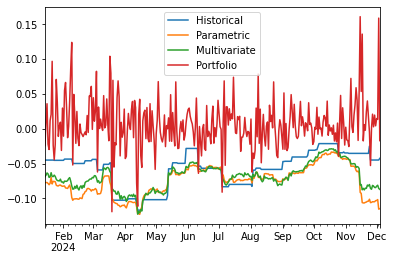

In [80]:
var_data.plot()

<AxesSubplot:>

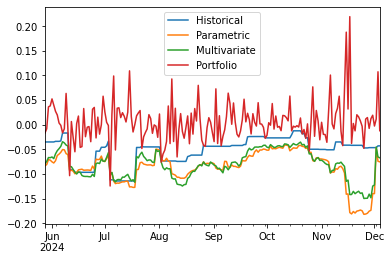

In [81]:
current_var_data.plot()

In [82]:
kupiec_test(var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.021472,0.009202,0.01227
Kupiec Stat,7.042947,17.007844,13.843197
P-value,0.007958,0.000037,0.000199


In [83]:
kupiec_test(current_var_data)

,Historical,Parametric,Multivariate
Proportion of failure,0.062827,0.015707,0.010471
Kupiec Stat,0.614003,6.386075,9.156305
P-value,0.433285,0.011502,0.002479


# Principal Component Analysis

## Historical PCA

In [84]:
eigval,eigvec,portfolio_components=historical_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.77188036, 0.07443203, 0.06014819, 0.05331588, 0.04022355])

In [85]:
pca_weight=dict((portfolio_components['PC1']/portfolio_components['PC1'].sum()))
portfolio_components['PC1']

AAVEUSDT    0.014613
ADAUSDT     0.014974
ALGOUSDT    0.016945
APEUSDT     0.017727
APTUSDT     0.015545
              ...   
WBTCUSDT    0.009453
WLDUSDT     0.021455
XLMUSDT     0.011803
XRPUSDT     0.010301
XTZUSDT     0.015671
Name: PC1, Length: 64, dtype: float64

<AxesSubplot:>

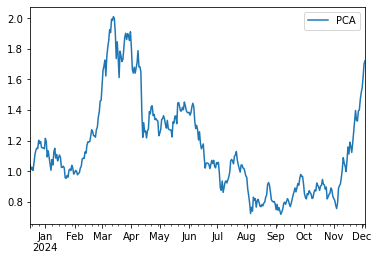

In [86]:
historical_PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(historical_risk.returns)),
                 index=historical_risk.returns.index,
                 columns=['PCA'])
historical_PCA=historical_PCA.dropna()
(1+historical_PCA).cumprod().plot()

<AxesSubplot:>

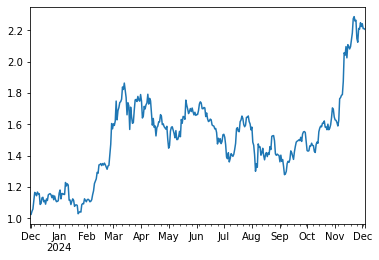

In [87]:
(1+historical_risk.returns['BTCUSDT']).cumprod().plot()

In [88]:
comparison=historical_risk.returns.copy()
comparison['PCA']=historical_PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-historical_PCA['PCA'])**2))).sort_values()
distances

PCA          0.000000
FLOWUSDT     0.398362
ETHUSDT      0.416671
WBETHUSDT    0.416829
EGLDUSDT     0.417918
               ...   
FLOKIUSDT    1.110673
BONKUSDT     1.120583
WLDUSDT      1.121181
PEPEUSDT     1.152377
OMUSDT       1.519707
Length: 65, dtype: float64

<AxesSubplot:>

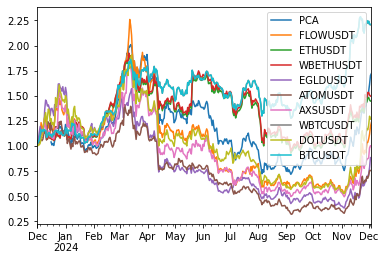

In [89]:
(1+comparison[distances.index[:10]]).cumprod().plot()

<AxesSubplot:>

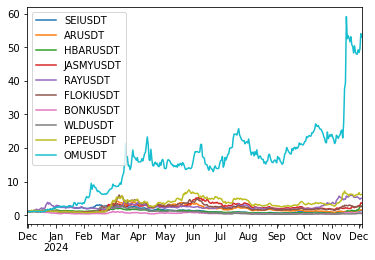

In [90]:
(1+comparison[distances.index[-10:]]).cumprod().plot()

## Current PCA

In [91]:
eigval,eigvec,portfolio_components_current=current_risk.pca(num_components=5)
variance_explained=eigval/eigval.sum()
variance_explained

array([0.54728705, 0.15581495, 0.1294129 , 0.10701513, 0.06046997])

In [92]:
pca_weight=dict((portfolio_components_current['PC1']/portfolio_components_current['PC1'].sum()))
portfolio_components_current['PC1']

OMUSDT       0.102125
BTCUSDT      0.063717
JASMYUSDT    0.158440
SOLUSDT      0.102951
ETHUSDT      0.084567
TRXUSDT      0.041383
BBUSDT       0.214279
BNBUSDT      0.067888
PEPEUSDT     0.164650
Name: PC1, dtype: float64

<AxesSubplot:>

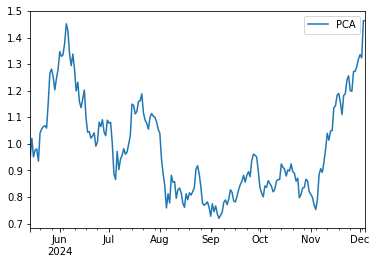

In [93]:
PCA=pd.DataFrame(np.array(list(pca_weight.values())).dot(np.transpose(current_risk.returns)),
                 index=current_risk.returns.index,
                 columns=['PCA'])
PCA=PCA.dropna()
(1+PCA).cumprod().plot()

<AxesSubplot:>

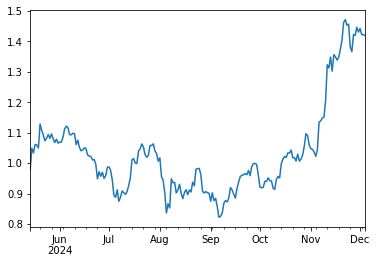

In [94]:
(1+current_risk.returns['BTCUSDT']).cumprod().plot()

In [95]:
comparison=current_risk.returns.copy()
comparison['PCA']=PCA
distances=np.sqrt(np.sum(comparison.apply(lambda y:(y-PCA['PCA'])**2))).sort_values()
distances.iloc[:10]

PCA          0.000000
SOLUSDT      0.378440
ETHUSDT      0.383739
BNBUSDT      0.399715
BTCUSDT      0.405052
JASMYUSDT    0.540583
PEPEUSDT     0.659232
BBUSDT       0.701411
TRXUSDT      0.836204
OMUSDT       0.861167
dtype: float64

<AxesSubplot:>

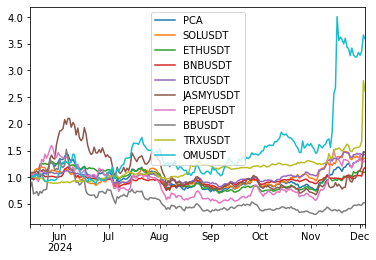

In [96]:
(1+comparison[distances.index[:10]]).cumprod().plot()

## Sensitivity Analysis

In [97]:
beta=(ex_ante_perf.cov()/ex_ante_perf.var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.908599
BBUSDT       1.530940
JASMYUSDT    1.259336
SOLUSDT      1.150278
BTCUSDT      1.000000
ETHUSDT      0.944330
OMUSDT       0.882150
BNBUSDT      0.652888
TRXUSDT      0.262218
Name: BTCUSDT, dtype: float64

In [98]:
days=15
beta=(ex_ante_perf.iloc[-days:].cov()/ex_ante_perf.iloc[-days:].var())['BTCUSDT'].sort_values(ascending=False)
beta

PEPEUSDT     1.658960
SOLUSDT      1.445184
BTCUSDT      1.000000
ETHUSDT      0.826590
BBUSDT       0.619974
BNBUSDT      0.603396
JASMYUSDT    0.422376
TRXUSDT      0.333624
OMUSDT      -0.165659
Name: BTCUSDT, dtype: float64

### Multilinear Regression

In [99]:
reg=ex_ante_perf.copy().dropna()
reg=reg.iloc[-30:]
reg['PCA']=historical_PCA
X=reg.iloc[:,reg.columns!='PCA'].to_numpy()
Y=reg['PCA'].to_numpy()
columns=list(reg.columns[reg.columns!='PCA'])

beta=np.dot(np.linalg.inv(np.dot(X.T,X)),np.dot(X.T,Y))

In [100]:
table=pd.DataFrame(dict(zip(columns,beta)).values(),index=dict(zip(columns,beta)).keys(),columns=['Beta'])
table

,Beta
OMUSDT,0.055585
BTCUSDT,0.648991
JASMYUSDT,0.336329
SOLUSDT,-0.215624
ETHUSDT,0.216651
TRXUSDT,-0.000615
BBUSDT,0.215475
BNBUSDT,-0.275476
PEPEUSDT,-0.008359


In [101]:
reg=ex_ante_perf.copy().dropna()
reg=reg.loc[historical_ptf['Historical Portfolio'].index]

reg['PCA']=historical_PCA
reg['Portfolio']=historical_ptf['Historical Portfolio']
reg=reg.iloc[-15:]
X=reg['PCA'].to_numpy()
Y=reg['Portfolio'].to_numpy()
columns=list(reg.columns[reg.columns!='Porfolio'])

beta=reg.cov()['Portfolio']['PCA']/reg.var()['Portfolio']
beta

0.5703321088411184

In [102]:
reg=ex_ante_perf.copy().dropna()
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.215520
BTCUSDT      1.211159
JASMYUSDT    0.474538
SOLUSDT      0.768823
ETHUSDT      0.929873
TRXUSDT      0.170855
BBUSDT       0.329882
BNBUSDT      1.067218
PEPEUSDT     0.372644
PCA          1.000000
dtype: float64

In [103]:
reg=ex_ante_perf.copy().dropna().iloc[-15:]
reg['PCA']=historical_PCA

reg.cov()['PCA']/reg.var()

OMUSDT       0.197786
BTCUSDT      0.653446
JASMYUSDT    0.261590
SOLUSDT      0.497585
ETHUSDT      0.282516
TRXUSDT      0.067451
BBUSDT       0.384577
BNBUSDT      0.502897
PEPEUSDT     0.248354
PCA          1.000000
dtype: float64

In [104]:
ex_ante_perf.corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,0.299379,0.161510,0.353082,0.231515,0.130450,0.267877,0.206740,0.171325
BTCUSDT,0.299379,1.000000,0.511403,0.708907,0.789211,0.177734,0.554330,0.594688,0.654578
JASMYUSDT,0.161510,0.511403,1.000000,0.467793,0.501655,0.268191,0.602140,0.480066,0.397869
SOLUSDT,0.353082,0.708907,0.467793,1.000000,0.661689,0.175492,0.548392,0.512202,0.545494
ETHUSDT,0.231515,0.789211,0.501655,0.661689,1.000000,0.163568,0.606039,0.585999,0.643313
TRXUSDT,0.130450,0.177734,0.268191,0.175492,0.163568,1.000000,0.138724,0.311687,0.117113
BBUSDT,0.267877,0.554330,0.602140,0.548392,0.606039,0.138724,1.000000,0.578202,0.474506
BNBUSDT,0.206740,0.594688,0.480066,0.512202,0.585999,0.311687,0.578202,1.000000,0.416871
PEPEUSDT,0.171325,0.654578,0.397869,0.545494,0.643313,0.117113,0.474506,0.416871,1.000000


In [105]:
ex_ante_perf.iloc[-15:].corr()

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
OMUSDT,1.000000,-0.105642,0.297194,0.034175,-0.449232,0.700264,0.186025,0.348124,-0.301190
BTCUSDT,-0.105642,1.000000,0.107911,0.865345,0.525699,0.043702,0.269441,0.357438,0.705211
JASMYUSDT,0.297194,0.107911,1.000000,0.351695,0.176424,0.697404,0.550674,0.742279,0.147436
SOLUSDT,0.034175,0.865345,0.351695,1.000000,0.589342,0.293779,0.547993,0.615140,0.765686
ETHUSDT,-0.449232,0.525699,0.176424,0.589342,1.000000,-0.101653,0.547924,0.234480,0.627465
TRXUSDT,0.700264,0.043702,0.697404,0.293779,-0.101653,1.000000,0.406309,0.812616,-0.029913
BBUSDT,0.186025,0.269441,0.550674,0.547993,0.547924,0.406309,1.000000,0.570291,0.347269
BNBUSDT,0.348124,0.357438,0.742279,0.615140,0.234480,0.812616,0.570291,1.000000,0.358581
PEPEUSDT,-0.301190,0.705211,0.147436,0.765686,0.627465,-0.029913,0.347269,0.358581,1.000000


## Sliding window optimization

In [106]:
results={}
window=14

for i in range(0,ex_ante_perf_to_use.shape[0]-window+1,window):
    
    try:
        dataset=ex_ante_perf_to_use.iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio')     
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=ex_ante_perf_to_use.columns).T
rolling_optimization

,OMUSDT,BTCUSDT,JASMYUSDT,SOLUSDT,ETHUSDT,TRXUSDT,BBUSDT,BNBUSDT,PEPEUSDT
2024-05-27,0.000000,0.000000,0.622138,0.000000,0.000000,0.000000,0.000000,0.000000,0.377862
2024-06-10,0.625881,0.000000,0.150844,0.000000,0.000000,0.223275,0.000000,0.000000,0.000000
2024-06-24,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000
2024-07-08,0.182521,0.000000,0.000000,0.000000,0.000000,0.817479,0.000000,0.000000,0.000000
2024-07-22,0.133222,0.414537,0.000000,0.111977,0.000000,0.340264,0.000000,0.000000,0.000000
2024-08-05,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2024-08-19,0.000000,0.000000,0.000000,0.000000,0.000000,0.926695,0.000000,0.073305,0.000000
2024-09-02,0.435173,0.000000,0.000000,0.000000,0.000000,0.564827,0.000000,0.000000,0.000000
2024-09-16,0.287486,0.000000,0.000000,0.000000,0.000000,0.000000,0.712514,0.000000,0.000000
2024-09-30,0.176594,0.000000,0.000000,0.000000,0.165826,0.527128,0.000000,0.000000,0.130451


In [107]:
results={}
window=30
days=250
limit=np.where(returns_to_use.columns=='USDCUSDT')[0][0]

for i in range(0,returns_to_use.shape[0]-window+1,window):
    
    try:
        dataset=returns_to_use.iloc[-days:].iloc[i:i+window]
        risk=RiskAnalysis(dataset)
        date=dataset.index[-1]
        optimal=risk.optimize(objective='sharpe_ratio',constraints=[{'type': 'eq', 'fun': lambda weights: weights[limit]-0.0}])
        results[date]=np.round(optimal,6)
        
    except Exception as e:
        
            pass

rolling_optimization=pd.DataFrame(results,index=returns_to_use.columns).T
rolling_optimization

,AAVEUSDT,ADAUSDT,ALGOUSDT,APEUSDT,APTUSDT,ARBUSDT,ARUSDT,ATOMUSDT,AVAXUSDT,AXSUSDT,...,TRXUSDT,UNIUSDT,USDCUSDT,VETUSDT,WBETHUSDT,WBTCUSDT,WLDUSDT,XLMUSDT,XRPUSDT,XTZUSDT
2024-04-28,0.013254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000
2024-05-28,0.013254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000
2024-06-27,0.013254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.953827,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000
2024-07-27,0.013254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.692237,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.067788,0.000000
2024-08-26,0.795288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.204712,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000
2024-09-25,0.105945,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000
2024-10-25,0.013256,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.674665,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.000000,0.000000
2024-11-24,0.013254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.16401,0.153891,0.035572
2024-12-04,0.013254,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.013984,0.00000,0.138048,0.000000


In [108]:
rolling_optimization.iloc[-1].sort_values(ascending=False)

STXUSDT     0.379932
TIAUSDT     0.214701
XRPUSDT     0.138048
SEIUSDT     0.120568
LDOUSDT     0.085648
              ...   
GRTUSDT     0.000000
HBARUSDT    0.000000
ICPUSDT     0.000000
IMXUSDT     0.000000
XTZUSDT     0.000000
Name: 2024-12-04 00:00:00, Length: 64, dtype: float64

<AxesSubplot:>

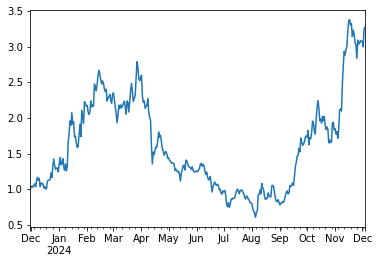

In [109]:
(1+returns_to_use['SUIUSDT']).cumprod().plot()